[This script demonstrates the use of a convolutional LSTM network.](https://keras.io/examples/conv_lstm/)

* Run on Google Colab due to GPU memory limits

In [1]:
%tensorflow_version 2.x
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt

TensorFlow 2.x selected.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
seq = Sequential([
    ConvLSTM2D(filters=40, kernel_size=(3,3),
               input_shape=(None,40,40,1),
               padding='same', return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=40, kernel_size=(3,3),
               padding='same', return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=40, kernel_size=(3,3),
               padding='same', return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=40, kernel_size=(3,3),
               padding='same', return_sequences=True),
    BatchNormalization(),
    Conv3D(filters=1, kernel_size=(3,3,3),
           activation='sigmoid', 
           padding='same', data_format='channels_last')
])

seq.compile(optimizer='adam',
            loss='binary_crossentropy')

seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 40)  1

In [0]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    
    for i in range(n_samples):
        n = np.random.randint(3, 8)
        
        for j in range(n):
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1
            
            w = np.random.randint(2,4)
            
            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, 
                             x_shift-w: x_shift+w, 
                             y_shift-w: y_shift+w, 0] += 1
                
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0,2)
                    noisy_movies[i, t,
                                 x_shift-w-1:x_shift+w+1,
                                 y_shift-w-1:y_shift+w+1, 0] += noise_f * 0.1
                
                x_shift = xstart + directionx * (t+1)
                y_shift = ystart + directiony * (t+1)
                shifted_movies[i, t,
                               x_shift-w: x_shift+w,
                               y_shift-w: y_shift+w, 0] += 1
            
    noisy_movies = noisy_movies[:,:,20:60,20:60,:]
    shifted_movies = shifted_movies[:,:,20:60,20:60,:]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [0]:
noisy_movies, shifted_movies = generate_movies(n_samples=1200)

In [7]:
history = seq.fit(noisy_movies[:1000], shifted_movies[:1000], 
                  batch_size=10, epochs=300, validation_split=0.05,
                  callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Train on 950 samples, validate on 50 samples
Epoch 1/300
950/950 [==============================] - 45s 47ms/sample - loss: 0.1951 - val_loss: 0.3358
Epoch 2/300
950/950 [==============================] - 33s 35ms/sample - loss: 0.0084 - val_loss: 0.3184
Epoch 3/300
950/950 [==============================] - 33s 35ms/sample - loss: 0.0032 - val_loss: 0.3292
Epoch 4/300
950/950 [==============================] - 33s 35ms/sample - loss: 0.0019 - val_loss: 0.3856
Epoch 5/300
950/950 [==============================] - 33s 35ms/sample - loss: 0.0013 - val_loss: 0.2737
Epoch 6/300
950/950 [==============================] - 33s 35ms/sample - loss: 9.5799e-04 - val_loss: 0.0327
Epoch 7/300
950/950 [==============================] - 33s 35ms/sample - loss: 7.3450e-04 - val_loss: 0.0017
Epoch 8/300
950/950 [==============================] - 33s 35ms/sample - loss: 5.9880e-04 - val_loss: 6.6764e-04
Epoch 9/300
950/950 [==============================] - 33s 35ms/sample - loss: 4.8743e-04 - val_los

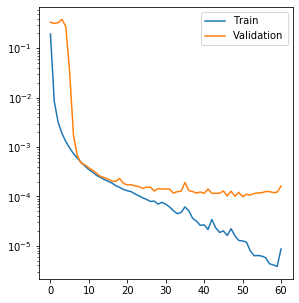

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], label='Train')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.legend(loc=1)
plt.yscale('log')
plt.show()

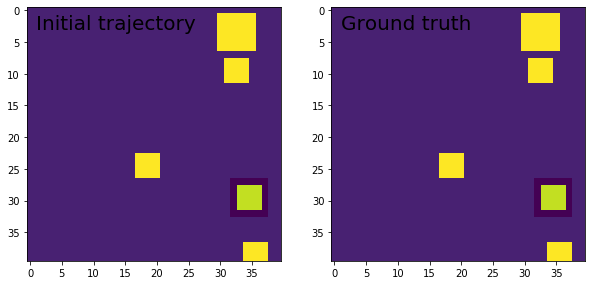

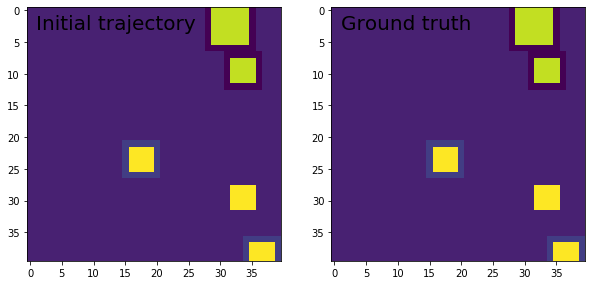

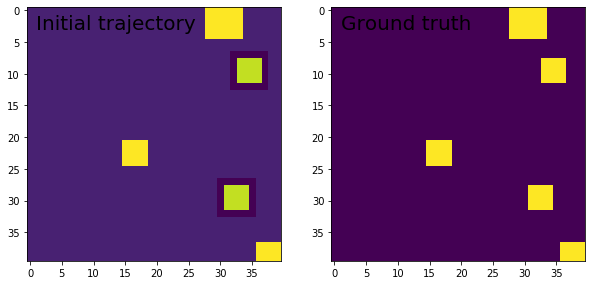

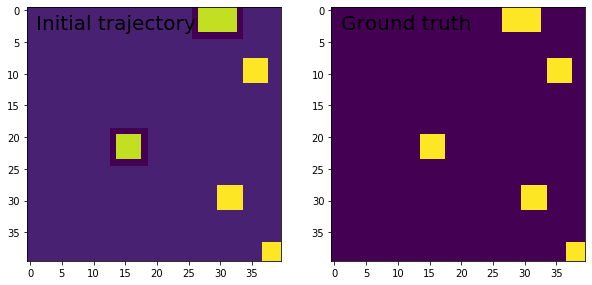

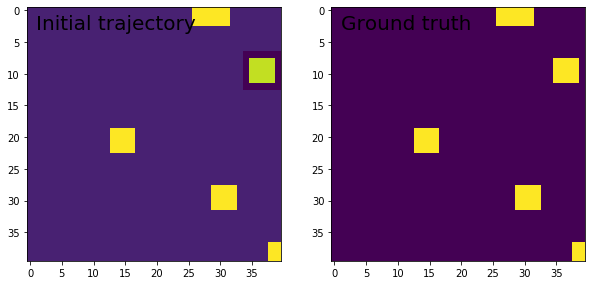

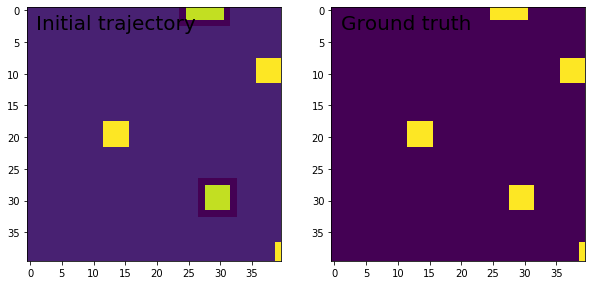

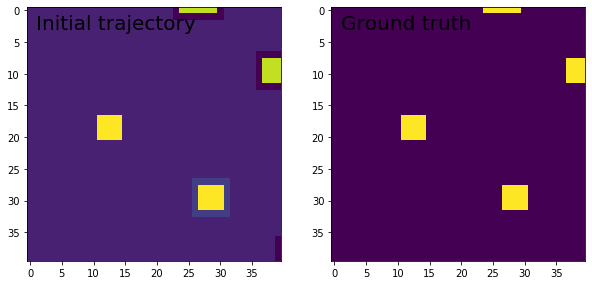

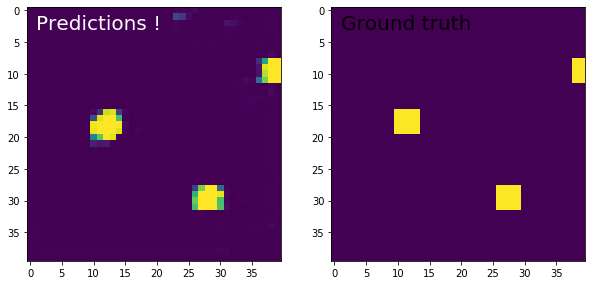

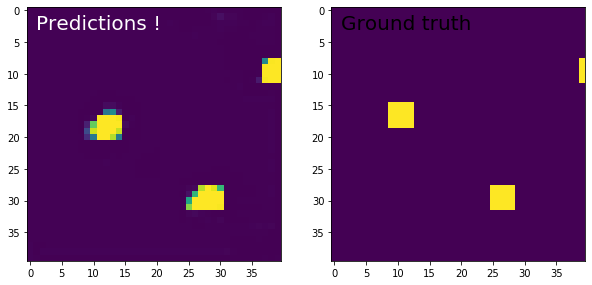

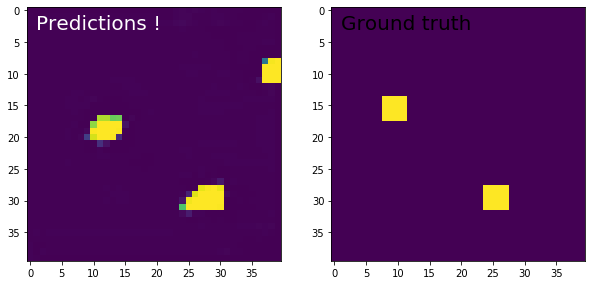

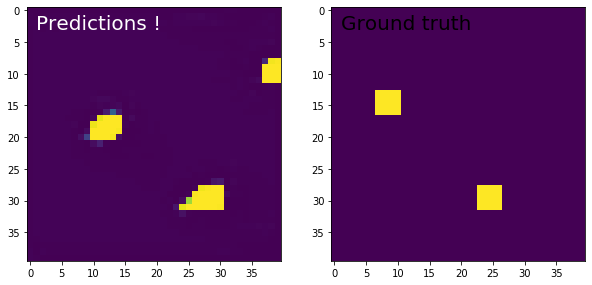

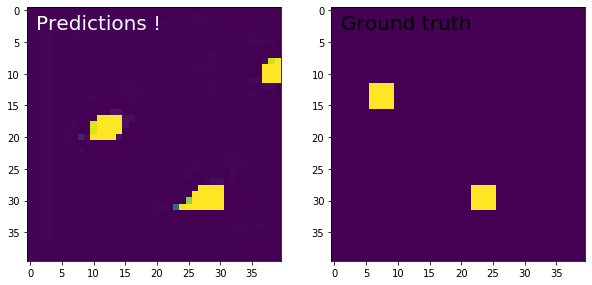

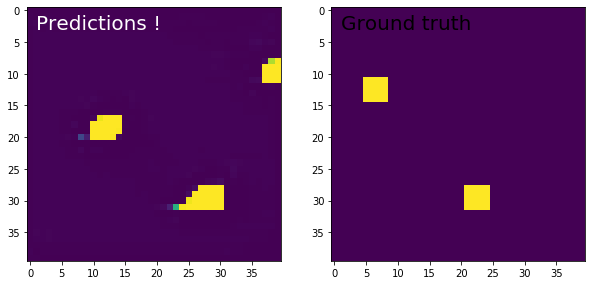

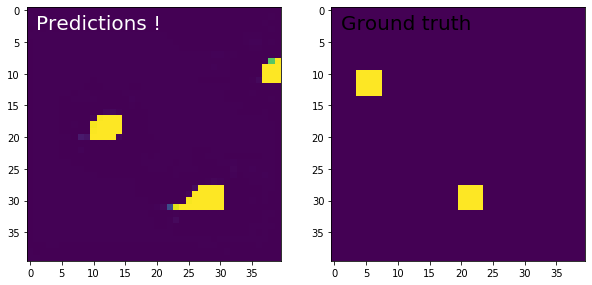

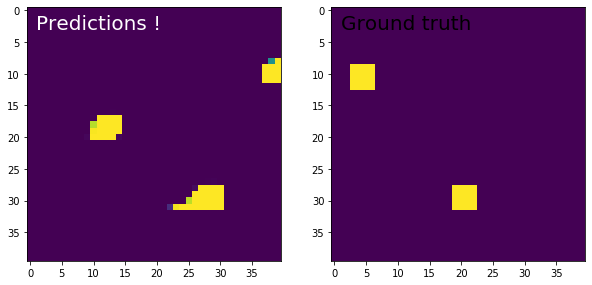

In [9]:
which = 1004
track = noisy_movies[which][:7, :, :, :]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, :, :, :, :])
    new = new_pos[:, -1, :, :, :]
    track = np.concatenate((track, new), axis=0)

track2 = noisy_movies[which][:, :, :, :]
for i in range(15):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    if i >= 7:
        plt.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', fontsize=20)
    
    toplot = track[i, :, :, 0]
    plt.imshow(toplot)
    
    plt.subplot(1,2,2)
    plt.text(1, 3, 'Ground truth', fontsize=20)
    
    toplot = track2[i, :, :, 0]
    if i >= 2:
        toplot = shifted_movies[which][i-1, :, :, 0]
    
    plt.imshow(toplot)
    plt.show()